# FEniCS simulation of a cantilever beam

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a cantilever beam ($\ell$: total length; $d$: depth), subjected to its own weight ($\rho$: mass density per unit volume; $g$: gravity) and tractions $\bar T$ applied to the right end.

The beam is homogenous and isotropic ($E$: Young modulus; $\nu$: Poisson ratio) and clamped on the left end. Hooke's law reads

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

**Question:** how does Hooke's law read in *plane stress* elasticity?

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1=0,x_2)=0\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
\int_{\partial\Omega\cap\{x=\ell\}}\overline{T}\cdot v\,\mathrm{d} y
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

In [1]:
import inspect

import dolfin, fenics
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pygments
import scipy.integrate

In [2]:
%matplotlib inline

## Geometry and mesh

In [3]:
ell = 1.0
d = ell/20.

**Notes (programming practices)**: 

- Avoid using the letter `l` as a variable name, as it is too close to the digit `1`. We therefore used `ell`.
    
- Write `20.` instead of `20` when the number should be cast into real number. Otherwise you can obtain results like `43/20 = 2` and consequent subtle bugs in your code.
    
- Note than we leave a white space before and after the `=` sign in the assignement. This and several other coding convention greatly improve readability. A complete list of convention is given in [PEP8](https://www.python.org/dev/peps/pep-0008/). We will test that you follow these conventions.

The typical size of the cells of the mesh is ``h``. FEniCS provides tools to generate the mesh of shapes as simple as rectangles.

In [4]:
h = d/16.
mesh = fenics.RectangleMesh(fenics.Point(0., -0.5*d), fenics.Point(ell, 0.5*d), int(ell/h), int(d/h))

The first two arguments of the ``RectangleMesh`` constructor are the lower-left and upper-right corners of the rectangle to be meshed. The 3rd and 4th arguments are the number of elements along the x and y directions.

Note that within a jupyter notebook, interactive help can be displayed through the use of the question mark as follows. Press ``Esc`` to close the help window.

In [5]:
fenics.RectangleMesh?

Docstring:      DOLFIN Mesh object
Init docstring:
__init__(*args, **kwargs)
Overloaded function.

1. __init__(self: dolfin.cpp.generation.RectangleMesh, p0: dolfin::Point, p1: dolfin::Point, nx: int, ny: int, diagonal: str = 'right') -> None

2. __init__(self: dolfin.cpp.generation.RectangleMesh, comm: MPICommWrapper, p0: dolfin::Point, p1: dolfin::Point, nx: int, ny: int, diagonal: str = 'right') -> None
Type:           pybind11_type
Subclasses:     


Use a double question mark to get a more detailed documentation (if available).

The mesh can be displayed as follows (use the pointer to rotate the mesh in 3d or zoom in).

In [6]:
#mesh

3D rotating a 2D mesh does not make much sense. The mesh can be plotted non-interactively as follows.

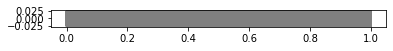

In [7]:
dolfin.plot(mesh)

``RectangleMesh`` has a 6th argument, ``diagonal``, that can be set to ``'right'`` (default) or ``'left'``. Notice the difference:

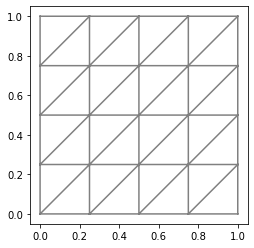

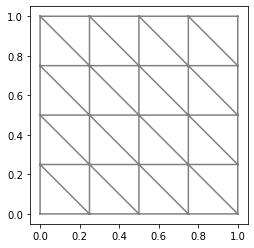

In [8]:
dolfin.plot(dolfin.RectangleMesh(dolfin.Point(0., 0.),
                                 dolfin.Point(1., 1.),
                                 4, 4, diagonal='right'))
plt.figure()
dolfin.plot(dolfin.RectangleMesh(dolfin.Point(0., 0.),
                                 dolfin.Point(1., 1.),
                                 4, 4, diagonal='left'))

### Marking the boundaries

In order to apply the various boundary conditions, it will be necessary to refer to specific sides of the mesh. The left and right borders are defined through [“callback functions”](https://en.wikipedia.org/wiki/Callback_%28computer_programming%29). A callback is a function to be passed as an argument to another function, which will then call the callback. In the present case, the callback is called to decide whether or not the node under consideration belongs to the specific border.

The signature of these callback functions must follow the FEniCS prescriptions

```python
callback_function(x, on_boundary)
```
    
where ``x`` is the array of coordinates of the point under consideration, while ``on_boundary`` is a boolean value that is ``True`` if the point belongs to the global boundary of the whole mesh. This second parameter is extremely useful, as it allows to quickly discard points that do not belong to the boundary (and therefore, certainly do not belong to the left or right boundaries!). In principle, we would like to define the function ``left`` as follows

In [9]:
def left(x, on_boundary):
    return x[0] == 0 and on_boundary

However, the above implementation has two flaws

1. Testing of exact equality is meaningless in floating-point arithmetics; see for example [What every computer scientist should know about Floating-Point Arithmetic](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html]). It makes more sense to test wether the point is close to the boundary, up to a specified fraction of the element-size.
2. The ordering of the logical ``and`` ought to be reverse, owing to [short-circuit evaluation](https://en.wikipedia.org/wiki/Short-circuit_evaluation).

A much better implementation is the following

In [10]:
atol = 1e-8*h

In [11]:
def left(x, on_boundary):
    return on_boundary and x[0] <= atol

Note that in the above test, we do not need to check that ``x[0] >= -atol``. The final refinement is to use a ``CompiledSubdomain``. This means that the callback function is written in C++, rather than pure Python. This is the recommended approach, since it improves the execution speed, and also avoids some weird scoping issues.

In [12]:
left = dolfin.CompiledSubDomain('on_boundary && x[0] <= atol', atol=atol)

**Notes:**
- The above expression between quotes is effectively a C++ expression! It **must** follow C++ syntax. For more information, refer to the comment “String expressions must have valid C++ syntax!” in section  [Defining the boundary conditions](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#___sec29) of chapter [Fundamentals: Solving the Poisson equation](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:fundamentals) of the [FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/ftut1.html).
- Note how we managed to pass the parameter ``atol`` to the function thus defined. The value of this parameter can be retrieved and modified with the `get_property`/`set_property` methods (see below)

In [13]:
left.get_property('atol')

3.125e-11

In [14]:
left.set_property('atol', atol)

**Question: ** similarly, define the ``right`` function.

## Variational formulation

### Discretization space

We adopt a displacement-based approach, where the only unknowns are the displacements. We use linear interpolation; note that this is a vector problem, and the element is in fact a ``VectorElement``.

In [15]:
degree = 1
element = dolfin.VectorElement('P', cell=mesh.ufl_cell(), degree=degree, dim=mesh.geometric_dimension())
V = dolfin.FunctionSpace(mesh, element)

### Strain-displacement and stress-strain operators

The strain-displacement operator is the operator $u_i\mapsto\frac12\bigl(\partial_i u_j+\partial_j u_i\bigr)$, where $u_i$ are the components of the displacement. FEniCS implementation is straightforward.

In [16]:
def strain_displacement(u):
    return dolfin.sym(dolfin.grad(u))

The stress-strain operator is the constitutive law that maps the strain tensor $\varepsilon$ onto the stress tensor $\sigma$ through Hooke's law.

In [17]:
E = 1.0
nu = 0.3

I2 = dolfin.Identity(mesh.geometric_dimension())
mu = dolfin.Constant(E/2./(1.+nu))
lambda_ = dolfin.Constant(E*nu/(1.+nu)/(1.-2.*nu))

def stress_strain(eps):
    return lambda_*dolfin.tr(eps)*I2+2*mu*eps

**Note:** ``lambda`` is a reserved keyword in Python. The common practice is to add a final underscore to define a variable called ``lambda_`` (see for example [Role of Underscore(_) in Python](https://www.datacamp.com/community/tutorials/role-underscore-python)).

**Question:** why did we set $E=1$?

### Bilinear and linear forms

The `UFL` (Unified Form Language) component provide a specific syntax to define variational forms, that are then used to automatically generate `C++` optimized codes to assemble matrices and vectors. We define in particular test and trial functions. 

In [18]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

The left-hand side of the variational formulation is the bilinear form, which reads in the present case

\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

In [19]:
bilinear_form = dolfin.inner(stress_strain(strain_displacement(u)),
                             strain_displacement(v))*dolfin.dx

The right-hand side of the variational formulation is the linear form, which is related to the loading. In the present case, the linear form reads

\begin{equation}
\int_{\partial\Omega\cap\{x=\ell\}}\overline{T}\cdot v\,\mathrm{d} y
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y.
\end{equation}

Owing to linearity, we can study the effect of both loads (end tractions and body forces) separately. We will show here how to implement both loads. Then, in the remainder of this notebook, we will concentrate on the body forces.

We first define the prescribed traction $\overline{T}$. In order to simplify the implementation of the first integral, we will use a trick. First, $\overline{T}$ will be defined as a function of both $x$ and $y$, which is zero unless $x=\ell$ (up to some tolerance).

In [20]:
traction = dolfin.Expression(('x[0] < x_right ? 0.0 : -12.*M/d/d/d*x[1]', '0.0'),
                             x_right=ell-atol, M=1.0, d=d, degree=degree)

**Note:** the above ``Expression`` must use valid ``C++`` syntax.

An alternative way to define an integral only on a part of the boundary or the bulk is to redefine the `measure` `dx` or `ds` to account for subdomain numbering. An example is given [here](https://gist.github.com/cmaurini/2030ee75a60a146c470713f23b70454f). See also Chapter 4 *Subdomains and boundary conditions* of the FEniCS tutorial.

**Questions:**

- What is the meaning of the `M` property in the `traction` expression?
- What is its physical dimension?
- Explain the expression of tractions that was adopted.

Using this trick, we can integrate the right-hand side over the *whole* boundary

In [21]:
linear_form = dolfin.dot(traction, v)*dolfin.ds

Body forces are implemented as follows

In [22]:
g = 1.
body_forces = dolfin.Constant((0., g))
M_max = 0.5*ell**2*d*g
linear_form = dolfin.dot(body_forces, v)*dolfin.dx

### Boundary conditions

Finally, we need to define the list of Dirichlet boundary conditions (prescribed displacements). Passing the ``left`` callback function defined above means that the BC applies to the $x=0$ boundary.

In [23]:
u_prescribed = dolfin.Constant((0., 0.))
boundary_condition_left = dolfin.DirichletBC(V, u_prescribed, left)

boundary_conditions = [boundary_condition_left]

## Solving the discretized problem

We no longer need the variable ``u`` defined as a ``TrialFunction``; ``u`` is now defined as a ``Function`` belonging to the space ``V``.

In [24]:
u = dolfin.Function(V)

Upon instantiation, ``u`` is initialized to zero. However, the following statement defines the variational problem we want to solve, and states that the solution is to be stored in ``u``.

In [25]:
problem = dolfin.LinearVariationalProblem(bilinear_form, linear_form, u, boundary_conditions)

At this point, the problem is defined, but inversion of the linear system has not been done.

In [26]:
solver = dolfin.LinearVariationalSolver(problem)
solver.solve()

That's it! Now ``u`` holds the solution to the problem! It can be represented as follows.

v_max = 545.9999999999999


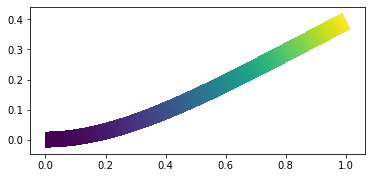

In [27]:
D = E*d**3/12./(1.-nu**2)
v_max = M_max*ell**2/4./D
print(f'v_max = {v_max}')
dolfin.plot((0.4/v_max)*u, mode='displacement')

**Question:** What is the meaning of the ``v_max``? Why did we scale ``u`` by ``0.4/v_max``?

We can also plot the deflection of the mid-line.

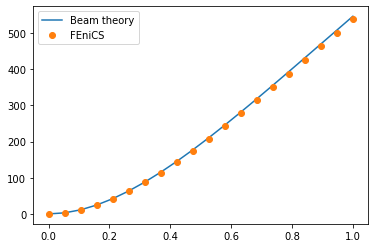

In [28]:
x = np.linspace(0., ell, num=20)
x_red = x/ell
v_fem = [u(x_i, 0.0)[1] for x_i in x]
v_fem = np.array(v_fem)

v_beam = v_max*(2.*x_red**2-4./3.*x_red**3+x_red**4/3.)

plt.plot(x, v_beam, label='Beam theory')
plt.plot(x, v_fem, 'o', label='FEniCS')
plt.legend()

Here is how we can compute and plot the stresses within the beam.

In [29]:
sig = stress_strain(strain_displacement(u))

V_sig = dolfin.FunctionSpace(mesh, dolfin.FiniteElement('DG', cell=mesh.ufl_cell(), degree=degree-1))
sig_xx = dolfin.project(sig[0, 0], V_sig)

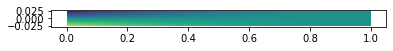

In [30]:
dolfin.plot(sig_xx)

We can plot $\sigma_{xx}$ at various locations along the beam

In [31]:
nx = 4
dx = ell/nx
x = np.linspace(0.5*dx, ell-0.5*dx, num=nx)
x_red = x/ell

In [32]:
ny = 10
dy = d/ny
y = np.linspace(-0.5*(d-dy), 0.5*(d-dy), num=ny)
y_red = 2.*y/d

(-1.0, 1.0)

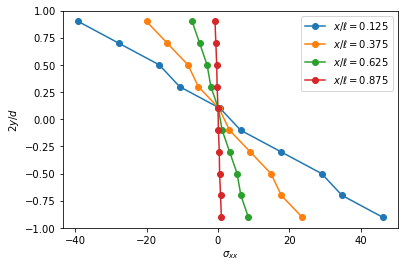

In [33]:
for x_i, x_red_i in zip(x, x_red):
    plt.plot([sig_xx(x_i, y_j) for y_j in y], y_red, 'o-', label=f'$x/\\ell = {x_red_i}$')
plt.legend()
plt.xlabel(r'$\sigma_{xx}$')
plt.ylabel(r'$2y/d$')
plt.ylim(-1., 1.)

Up to discretization errors, the stress profile is linear. The slope is not constant, as expected.

**Questions:**

- Why didn't we compute the value of $\sigma_{xx}$ at the upper and lower faces ($y=\pm d/2$)?
- Why didn't we plot the stress profiles at the left and right boundaries ($x=0$, $x=L$)?
- What is the meaning of the slope of the above diagram?

We can also compute the bending moments as a function of $x$

\begin{equation}
M(x) = -\int_{-d/2}^{d/2}y\,\sigma_{xx}(x, y)\,\mathrm{d}y.
\end{equation}

In [34]:
nx = 20
dx = ell/nx
x = np.linspace(0.5*dx, ell-0.5*dx, num=nx)

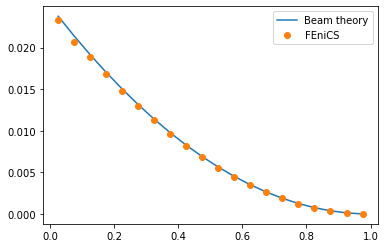

In [35]:
M = np.empty_like(x)
for i, x_i in enumerate(x):
    integrand = np.vectorize(lambda y: -y*sig_xx(x_i, y))
    M[i], _ = scipy.integrate.quad(integrand, -.5*d, .5*d)
    
plt.plot(x, M_max*(1-x/ell)**2, label='Beam theory')
plt.plot(x, M, 'o', label='FEniCS')
plt.legend()

**Question:** does the bending moment diagram agree with what you would have expected? Does the beam need to be slender for this bending moment diagram to be valid?

## Putting it all together

The above script uses a lot of global variables, which is asking for trouble. It is time to [refactor](https://en.wikipedia.org/wiki/Code_refactoring) our code into a class. This will also ease parametric studies. The class is actually defined in an external module, that we must first import.

In [36]:
from cantilever import Cantilever

The whole simulation is encapsulated into the ``Cantilever`` class, which is listed below.

In [37]:
IPython.core.display.HTML(pygments.highlight(inspect.getsource(Cantilever),
                                             pygments.lexers.PythonLexer(),
                                             pygments.formatters.HtmlFormatter(full=True)))

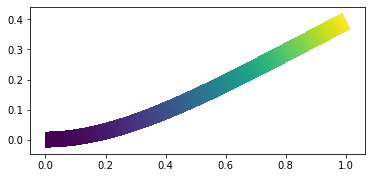

In [39]:
example = Cantilever(d, h)
dolfin.plot(0.4/v_max*example.solution(), mode='displacement')

We are now ready to carry out parametric studies. Here is an uncommented example.

In [ ]:
degree = 1
h = d
element_sizes = []
maximum_deflections = []
for _ in range(8):
    example = Cantilever(d, h, ell=ell, degree=degree)
    u = example.solution()
    element_sizes.append(h)
    maximum_deflection = u(ell, 0.)[1]
    maximum_deflections.append(maximum_deflection)
    plt.figure()
    fenics.plot(example.V.mesh())
    plt.title("h: {:4.2e}, u_max: {:4.2e}".format(h,maximum_deflection))
    h *= 0.5

In [ ]:
element_sizes = np.array(element_sizes)
maximum_deflections = np.array(maximum_deflections)

In [ ]:
plt.loglog(element_sizes, maximum_deflections, 'o')
plt.xlabel('element_size')
plt.ylabel('deflection')

In [ ]:
order = example.degree+1

v2, v1 = maximum_deflections[-2:]
h2, h1 = element_sizes[-2:]

v_ref = (v1*h2**order-v2*h1**order)/(h2**order-h1**order)
const = np.abs((v1-v_ref)/v_ref/h1**order)
err = np.abs((maximum_deflections-v_ref)/v_ref)
plt.loglog(element_sizes, const*element_sizes**order)
plt.loglog(element_sizes, err, 'o')